# SEA-AD

Seattle Alzheimer's Disease Brain Cell Atlas (SEA-AD) was accessed on 01.09.2024 from https://registry.opendata.aws/allen-sea-ad-atlas.

Data overview: https://portal.brain-map.org/explore/seattle-alzheimers-disease/seattle-alzheimers-disease-brain-cell-atlas-download?edit&language=en

In [1]:
# import standard packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import anndata as ad

# import single-cell packages
import scanpy as sc
#import squidpy as sq

#from spatialdata_io import merscope #spatialdata reader

from pathlib import Path

# set verbosity levels
sc.settings.verbosity = 2

## Set up paths

In [2]:
sys.path.insert(0, "../")  # this depends on the notebook depth and must be adapted per notebook

SEA_AD = '/lustre/groups/ml01/projects/2023_ad_jaekel/sea_ad'
HICHHIKERS_SEAAD = '/lustre/groups/ml01/datasets/projects/2024_hitchhickers_guide_to_spatial_project_sara.jimenez_francesca.drummer/'

## Set global parameters

In [6]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['savefig.dpi'] = 300 # If 'figure', uses the figure's dpi value.
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Load SEA-AD data

Squidpy tutorial: [Analyze Merfish data](https://squidpy.readthedocs.io/en/latest/notebooks/tutorials/tutorial_merfish.html)

In [4]:
adata = sc.read_h5ad(Path(HICHHIKERS_SEAAD, 'unprocessed_data/brain_mtg_merfish.h5ad'))
adata

AnnData object with n_obs × n_vars = 366272 × 180
    obs: 'Donor ID', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'APOE4 Status', 'Primary Study Name', 'Secondary Study Name', 'Class', 'Subclass', 'Supertype', 'Supertype confidence', 'napari_1', 'napari_2', 'Section', 'Specimen Barcode', 'Genes detected', 'Number of spots', 'Layer annotation', 'Merscope', 'Cell volume', 'Cell ID', 'Used in analysis'
    uns: 'APOE4 Status_colors', 'Braak_colors', 'Sex_colors', 'Subclass_colors', 'Supertype_colors', 'X_normalization', 'batch_condition', 'cluster_colors', 'default_embedding', 'fname', 'status', 'subclass_colors', 'title'
    obsm: 'X_selected

In [5]:
adata.X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 5, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
# average number of transcripts per cell
if not isinstance(adata.X, np.ndarray):
    expr_matrix = adata.X.toarray()
else:
    expr_matrix = adata.X

# Count the number of non-zero entries per cell (row)
genes_per_cell = (expr_matrix > 0).sum(axis=1)

# Compute the average number of genes per cell
average_genes_per_cell = np.mean(genes_per_cell)

print(f"Average number of genes per cell: {average_genes_per_cell}")

Average number of genes per cell: 52.66477372007688


In [29]:
donors = np.unique(adata.obs['Donor ID'])
print('Nr. of donors: ', len(donors))
donors

Nr. of donors:  27


array(['H20.33.001', 'H20.33.004', 'H20.33.012', 'H20.33.015',
       'H20.33.025', 'H20.33.035', 'H20.33.040', 'H20.33.044',
       'H21.33.001', 'H21.33.005', 'H21.33.006', 'H21.33.011',
       'H21.33.012', 'H21.33.013', 'H21.33.014', 'H21.33.015',
       'H21.33.016', 'H21.33.019', 'H21.33.021', 'H21.33.022',
       'H21.33.023', 'H21.33.025', 'H21.33.028', 'H21.33.031',
       'H21.33.032', 'H21.33.038', 'H21.33.040'], dtype=object)

In [45]:
sections = np.unique(adata.obs['Section'])
print('Nr. of sections: ', len(sections))
sections[:3]

Nr. of sections:  69


array(['H20.33.001.CX28.MTG.02.007.1.02.02',
       'H20.33.001.CX28.MTG.02.007.1.02.03',
       'H20.33.001.Cx28.MTG.02.007.1.01.03'], dtype=object)

In [8]:
adata.var_names

Index(['PRRT4', 'GRIP2', 'FOXP2', 'PDZD2', 'KIAA1217', 'PALMD', 'LRRC4C',
       'ASIC2', 'NPAS3', 'LUZP2',
       ...
       'Blank-34', 'Blank-37', 'Blank-27', 'Blank-25', 'Blank-10', 'Blank-35',
       'Blank-13', 'Blank-9', 'Blank-0', 'Blank-33'],
      dtype='object', length=180)

Most donors have 3 sections but some have left. Section count per donor?

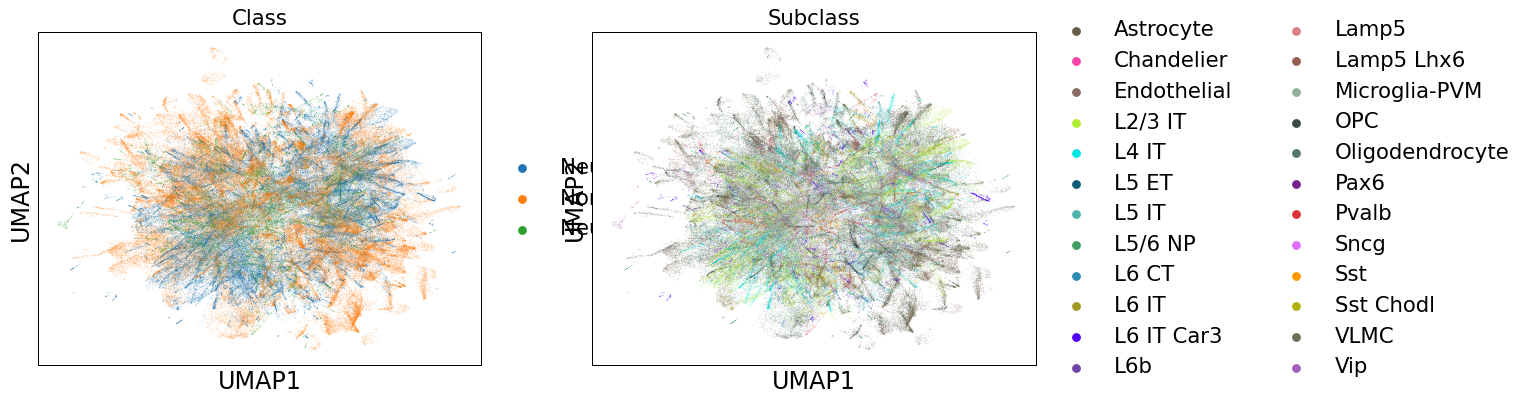

In [12]:
sc.pl.umap(adata, color=['Class', 'Subclass'])

- UMAP doesnt look preprocessed, or is this just the characteristic of ST?

In [20]:
total_cells = len(adata)
oligo_count = len(adata[adata.obs['Subclass'] == "Oligodendrocyte"])
OPC_count = len(adata[adata.obs['Subclass'] == "OPC"])
print(f'Nr. of Oligodendrocytes: {oligo_count} ({np.round(oligo_count/total_cells * 100,2)}%) and OPCs: {OPC_count} ({np.round(OPC_count/total_cells * 100,2)}%)')

Nr. of Oligodendrocytes: 50570 (13.81%) and OPCs: 13811 (3.77%)


In [22]:
sc.pl.violin(adata, groupby='Supertype')

TypeError: violin() missing 1 required positional argument: 'keys'

/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/scanpy/lib/python3.10/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/scanpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


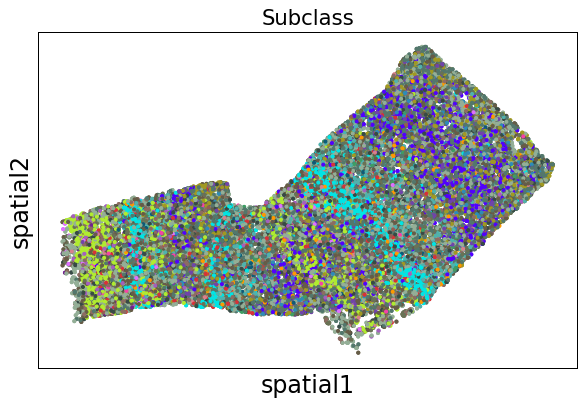

In [6]:
sq.pl.spatial_scatter(
    adata[adata.obs['Donor ID'] == 'H20.33.001'], shape=None, color="Subclass", size=20, legend_fontsize = 10, legend_loc = None
)

/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/scanpy/lib/python3.10/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/scanpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/scanpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/scanpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored

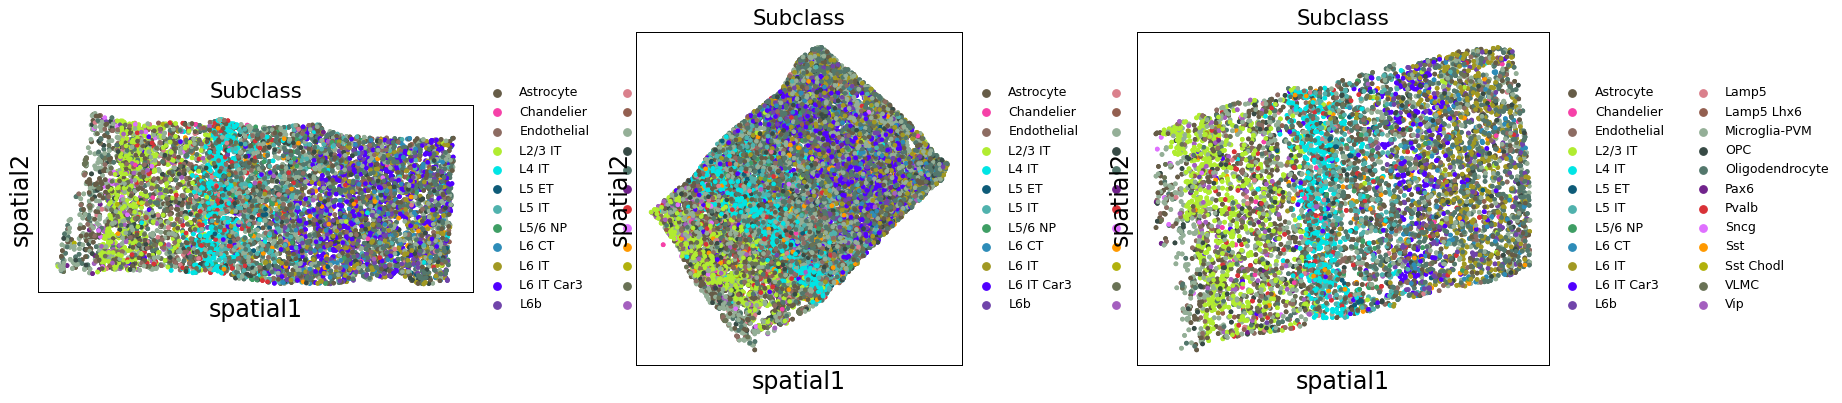

In [49]:
adata_donor1 = adata[adata.obs['Donor ID'] == 'H20.33.001']
sq.pl.spatial_scatter(
    adata_donor1, library_key = 'Section', shape=None, color="Subclass", size=30, legend_fontsize = 10
)

Q: Are there any Oligo or OPC characteristic genes in the data?

In [54]:
print(adata.var_names[:100])
print(adata.var_names[100:])

Index(['PRRT4', 'GRIP2', 'FOXP2', 'PDZD2', 'KIAA1217', 'PALMD', 'LRRC4C',
       'ASIC2', 'NPAS3', 'LUZP2', 'GRIN2A', 'NLGN1', 'NTNG2', 'TACR1', 'PDGFD',
       'ANK1', 'DLX1', 'CBLN2', 'ZNF804A', 'CACNA2D3', 'CDH6', 'CD22',
       'ETNPPL', 'CALB1', 'TSHZ2', 'FGF13', 'KIRREL3', 'ROBO1', 'RBFOX3',
       'ASTN2', 'ID3', 'TH', 'TENM2', 'ZMAT4', 'CLSTN2', 'SEMA6D', 'HPSE2',
       'BTBD11', 'LRP1B', 'NOS1', 'GPC5', 'SNTB1', 'COL11A1', 'TMEM255A',
       'SATB2', 'SORCS3', 'FBXL7', 'GRM8', 'GALNTL6', 'NOSTRIN', 'DCC', 'SOX6',
       'MEIS2', 'STXBP6', 'SMYD1', 'SCUBE1', 'LAMA4', 'CNTN5', 'GRM7',
       'KCNMB2', 'CUX2', 'LAMP5', 'SLIT3', 'TAFA1', 'PRKG1', 'CSMD1',
       'CNTNAP5', 'NFIA', 'FRMPD4', 'GRID2', 'HS6ST3', 'SORCS1', 'ATRNL1',
       'ADAMTS3', 'SLC24A2', 'RBFOX1', 'TMEM132D', 'NKAIN2', 'PEX5L', 'TNR',
       'DGKG', 'RFX3', 'UNC5B', 'HTR2A', 'RGS12', 'CACHD1', 'RORB', 'LRRK1',
       'THEMIS', 'CARTPT', 'SLC32A1', 'GAD2', 'MOG', 'DCN', 'TOX', 'ZNF385D',
       'PDE4B', 'GRIP1'

# snRNA-seq data

In [ ]:
adata_sn = sc.read_h5ad(Path(HICHHIKERS_SEAAD, 'SEAAD/SEAAD_MTG_RNAseq_final-nuclei.2024-02-13.h5ad'))
adata_sn

In [ ]:
adata_sn_sub.write('/lustre/groups/ml01/datasets/projects/2024_hitchhickers_guide_to_spatial_project_sara.jimenez_francesca.drummer/unprocessed_data/brain_mtg_snRNA.h5ad')

In [6]:
np.unique(adata_sn.obs['Donor ID'])

array(['H18.30.001', 'H18.30.002', 'H19.30.001', 'H19.30.002',
       'H19.33.004', 'H20.33.001', 'H20.33.002', 'H20.33.004',
       'H20.33.005', 'H20.33.008', 'H20.33.011', 'H20.33.012',
       'H20.33.013', 'H20.33.014', 'H20.33.015', 'H20.33.016',
       'H20.33.017', 'H20.33.018', 'H20.33.019', 'H20.33.020',
       'H20.33.024', 'H20.33.025', 'H20.33.026', 'H20.33.027',
       'H20.33.028', 'H20.33.029', 'H20.33.030', 'H20.33.031',
       'H20.33.032', 'H20.33.033', 'H20.33.034', 'H20.33.035',
       'H20.33.036', 'H20.33.037', 'H20.33.038', 'H20.33.039',
       'H20.33.040', 'H20.33.041', 'H20.33.043', 'H20.33.044',
       'H20.33.045', 'H20.33.046', 'H200.1023', 'H21.33.001',
       'H21.33.002', 'H21.33.003', 'H21.33.004', 'H21.33.005',
       'H21.33.006', 'H21.33.007', 'H21.33.008', 'H21.33.009',
       'H21.33.010', 'H21.33.011', 'H21.33.012', 'H21.33.013',
       'H21.33.014', 'H21.33.015', 'H21.33.016', 'H21.33.017',
       'H21.33.018', 'H21.33.019', 'H21.33.020', 'H21.33

In [8]:
# subset snRNA-seq data to donors included in spatial data
spatial_donor_ids = adata.obs['Donor ID'].unique()
adata_sn_sub = adata_sn[adata_sn.obs['Donor ID'].isin(spatial_donor_ids)]
adata_sn_sub

In [7]:
adata_sn_sub = sc.read_h5ad(Path(HICHHIKERS_SEAAD, 'SEAAD/brain_snRNA_subsest.h5ad'))
adata_sn_sub

AnnData object with n_obs × n_vars = 435782 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Number of mapped reads', 'Number of unmapped reads', 'Number of multimapped reads', 'Number of reads', 'Number of UMIs', 'Genes detected', 'Doublet score', 'Fraction mitochondrial UMIs', 'Used in analysis', 'Class confidence', 'Class', 'Subclass confidence', 'Subclass', 'Supertype confidence', 'Supertype (non-expanded)', 'Supertype'
    var: 'gene_ids'
    uns: 'APOE4 Status_colors', 'Braak_colors', 'CERAD score_colors', 'Cognitive Status_colors', 'Great Apes Metadata', 'Highest Lewy Body Disease_colors', 'LATE_colors', 'Overall 

In [9]:
adata_sn_sub.write('/lustre/groups/ml01/datasets/projects/2024_hitchhickers_guide_to_spatial_project_sara.jimenez_francesca.drummer/unprocessed_data/brain_mtg_snRNA_matched.h5ad')

In [28]:
for obs in ['Continuous Pseudo-progression Score', 'Severely Affected Donor']:
    del adata_sn_sub.obs[obs]

In [29]:
adata_sn_sub

View of AnnData object with n_obs × n_vars = 435782 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Number of mapped reads', 'Number of unmapped reads', 'Number of multimapped reads', 'Number of reads', 'Number of UMIs', 'Genes detected', 'Doublet score', 'Fraction mitochondrial UMIs', 'Used in analysis', 'Class confidence', 'Class', 'Subclass confidence', 'Subclass', 'Supertype confidence', 'Supertype (non-expanded)', 'Supertype'
    var: 'gene_ids'
    uns: 'APOE4 Status_colors', 'Braak_colors', 'CERAD score_colors', 'Cognitive Status_colors', 'Great Apes Metadata', 'Highest Lewy Body Disease_colors', 'LATE_colors', '

In [30]:
adata_sn_sub.write('/lustre/groups/ml01/datasets/projects/2024_hitchhickers_guide_to_spatial_project_sara.jimenez_francesca.drummer/SEAAD/brain_snRNA_subsest.h5ad')

In [31]:
import sys
size = sys.getsizeof(adata_sn_sub)
print(f"Size of the object: {size} bytes")

Size of the object: 59440480446 bytes


## SpatialData object

Useful references:

- [SPArrOW: Load to zarr and load the image](https://sparrow-pipeline.readthedocs.io/en/latest/tutorials/SPArrOW_how_to_start.html)
- [spatialdata-io: read MERSCOPE](https://spatialdata.scverse.org/projects/io/en/latest/generated/spatialdata_io.merscope.html)
- [Issue: MERFISH data analysis from scratch](https://discourse.scverse.org/t/merfish-data-analysis-from-scratch/1477/1)

In [14]:
import tifffile
from spatialdata_io import merscope
from spatialdata import SpatialData, models
from spatial_image import SpatialImage
from spatialdata.models import Image2DModel
#from affine import Affine
import dask.array as da

import numpy as np
#import sparrow as sp
import xarray as xr

In [6]:
patient_1 = 'H20.33.002'
slides = ['1217501037', '1217501042']

In [8]:
MERFISH_PATH  = Path(HICHHIKERS_SEAAD, patient_1, slides[0])

In [18]:
merscope(MERFISH_PATH, mosaic_images = False)

FileNotFoundError: /lustre/groups/ml01/datasets/projects/2024_hitchhickers_guide_to_spatial_project_sara.jimenez_francesca.drummer/H20.33.002/1217501037/images/micron_to_mosaic_pixel_transform.csv not found.

In [10]:
dapi_image = tifffile.imread(Path(HICHHIKERS_SEAAD, patient_1, slides[0], 'DAPI_Max.tif'))

In [56]:
# Define pixel size in physical units (e.g., micrometers per pixel)
pixel_size = 0.1  # Adjust this value based on your data

# Create an affine transformation
transform = Affine.scale(pixel_size, pixel_size)
# Get the default coordinate system from SpatialData
coordinate_system = SpatialData.coordinate_systems

In [57]:
dapi_image = tifffile.imread(Path(HICHHIKERS_SEAAD, patient_1, slides[0], 'DAPI_Max.tif'))

# Create an xarray DataArray for the DAPI image
dapi_dataarray = xr.DataArray(
    dapi_image,
    dims=("y", "x"),
    name='DAPI',
    attrs={
        'transform': transform,
        'coordinate_system': coordinate_system,
    }
)

Load array as dask array

In [63]:
chunk_size = (1024, 1024)
dapi_image = da.from_array(dapi_dataarray, chunks=chunk_size)

In [64]:
images = {
    'DAPI': dapi_image,
    #'PolyT': polyt_dataarray
}

# Create the SpatialData object
sdata = SpatialData(images=images, tables=adata)

TypeError: Unsupported type <class 'dask.array.core.Array'>

In [30]:
dapi_spatial_image = SpatialImage(dapi_image, dims=("y", "x"))
dapi_spatial_image

<xarray.SpatialImage (y: 79731, x: 98819)> Size: 16GB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Dimensions without coordinates: y, x

In [31]:
#sdata = SpatialData(images={'DAPI': dapi_image}, tables=adata)

In [38]:
ROOT_MERSCOPE = Path(HICHHIKERS_SEAAD, 'H20.33.002')

In [41]:
models.Image2DModel.parse(dapi_image)

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


IndexError: tuple index out of range

In [37]:
merscope(ROOT_MERSCOPE)

FileNotFoundError: /lustre/groups/ml01/projects/2024_hitchhickers_guide_to_spatial_project_francesca.drummer/data/unprocessed/SEAAD/H20.33.002/images/micron_to_mosaic_pixel_transform.csv not found.

Load raw data from MERSCOPE into SpatialData Zarr format.

In [25]:
path_image = Path(HICHHIKERS_SEAAD, patient_1, slides[0], 'DAPI_Max.tif')
OUTPUT_DIR = Path(HICHHIKERS_SEAAD, patient_1, slides[0])
crd = [0, 2144 * 3, 0, 2144 * 3]  # crd: for tiling correction, the image size needs to be a multiple of the tiling size

In [21]:
sdata = SpatialData(images={'DAPI': dapi_image}, tables=adata)

TypeError: Unsupported type <class 'numpy.ndarray'>

In [20]:
sdata = sp.io.create_sdata(
    input=path_image, output_path=os.path.join(OUTPUT_DIR, "sdata.zarr"), img_layer='raw_image', chunks=1024, crd=crd
)

INFO     The Zarr backing store has been changed from None the new file path:                                      
         /lustre/groups/ml01/projects/2024_hitchhickers_guide_to_spatial_project_francesca.drummer/data/unprocessed
         /SEAAD/H20.33.002/1217501037/sdata.zarr                                                                   


2024-10-04 10:45:46,552 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is (c, (z), y, x)
2024-10-04 10:45:46,714 - sparrow.image._manager - INFO - Writing results to layer 'raw_image'


RuntimeError: The functions add_image(), add_labels(), add_points() and add_shapes() have been removed in favor of dict-like access to the elements. Please use the following syntax to add an element:

	sdata.images["image_name"] = image
	sdata.labels["labels_name"] = labels
	...

The new syntax does not automatically updates the disk storage, so you need to call sdata.write() when the in-memory object is ready to be saved.
To save only a new specific element to an existing Zarr storage please use the functions write_image(), write_labels(), write_points(), write_shapes() and write_table(). We are going to make these calls more ergonomic in a follow up PR.

### Vizualize data

MERFISH tutorial: https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/technology_merfish.html